In [1]:
import numpy as np
import torch
import torch.nn as nn
import models.lstm_scene_to_scene02 as clstm 
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [2]:
model = clstm.LSTMSceneToScene02(hidden_dim=128)

state_dict = torch.load(r"C:\Users\morit\OneDrive\Desktop\adlr_model\scene_convlstm_study01_e5.pt", map_location="cpu")
model.load_state_dict(state_dict['model_state_dict'])

model.eval()



LSTMSceneToScene02(
  (convLSTM): StackedConvLSTM(
    (layers): ModuleList(
      (0): ConvLSTM(
        (cell): ConvLSTMCell(
          (conv): Conv2d(129, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (1): ConvLSTM(
        (cell): ConvLSTMCell(
          (conv): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
    )
  )
  (decoder): Conv2d(128, 1, kernel_size=(1, 1), stride=(1, 1))
  (activation): Sigmoid()
)

In [3]:
data = np.load(r"C:\Users\morit\OneDrive\Desktop\adlr_model\dynamic_scenes2d_motionv01_64_10_1000_100_vel0_pt09.npy")

In [4]:
data.shape
frames = torch.Tensor(data[4][:5])
frames.shape


torch.Size([5, 64, 64])

In [5]:
image = model.forward_multi_step(frames.unsqueeze(0), 10).detach().numpy()

In [6]:
image.shape

(1, 10, 64, 64)

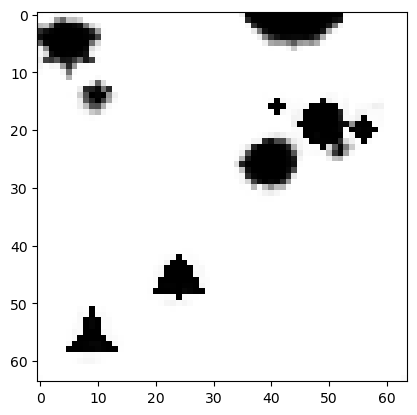

In [35]:
plt.imshow(image[0][0], cmap='binary')


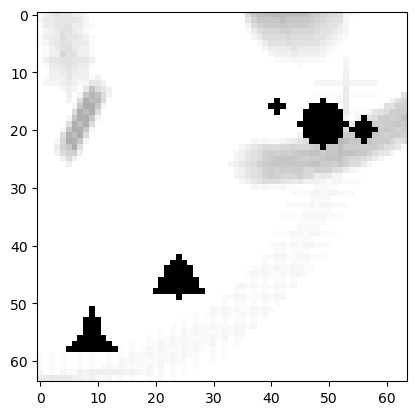

In [11]:
plt.imshow(np.sum(data[4][:50], axis = 0), cmap='binary')

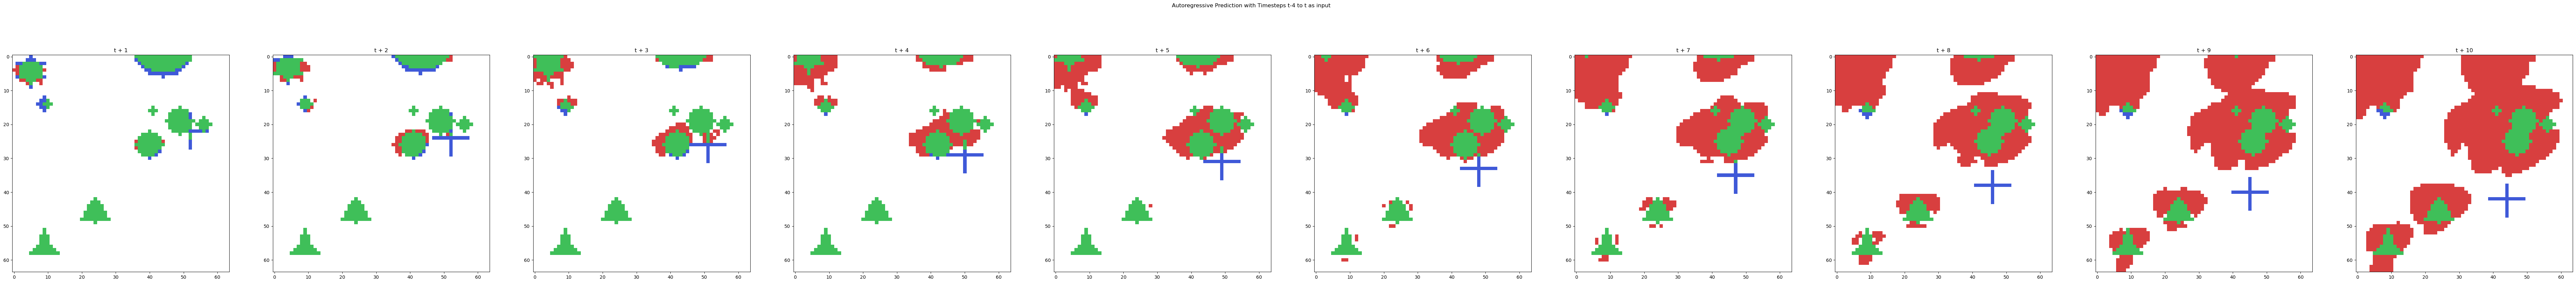

In [6]:
threshold = 0.9
num_steps = 10

fig, axs = plt.subplots(1, 10, figsize=(100,10))

for i in range(num_steps):
    
    img1 = (data[4][5 + i] > threshold).astype(int)
    img2 = (image[0][i] > threshold).astype(int)

    match = np.array([(img1 == 1) & (img2 == 1)], dtype=int)

    

    img = img1 + 2* img2 + match
    img = img.squeeze(0)

    rgb = np.ones((img.shape[0], img.shape[1], 3))

    rgb[img == 0] = [1, 1, 1]  # white
    rgb[img == 1] = [0.25, 0.35, 0.85]
    rgb[img == 2] = [0.85, 0.25, 0.25]
    rgb[img == 4] = [0.25, 0.75, 0.35]
    axs[i].imshow(rgb)
    axs[i].set_title(f"t + {i + 1}")

fig.suptitle("Autoregressive Prediction with Timesteps t-4 to t as input")
plt.show()

In [9]:
print(data[4].shape)

(100, 64, 64)


(64, 64) (64, 64) (64, 64)
(64, 64)
(64, 64) (64, 64) (64, 64)
(64, 64)
(64, 64) (64, 64) (64, 64)
(64, 64)
(64, 64) (64, 64) (64, 64)
(64, 64)
(64, 64) (64, 64) (64, 64)
(64, 64)
(64, 64) (64, 64) (64, 64)
(64, 64)
(64, 64) (64, 64) (64, 64)
(64, 64)
(64, 64) (64, 64) (64, 64)
(64, 64)
(64, 64) (64, 64) (64, 64)
(64, 64)


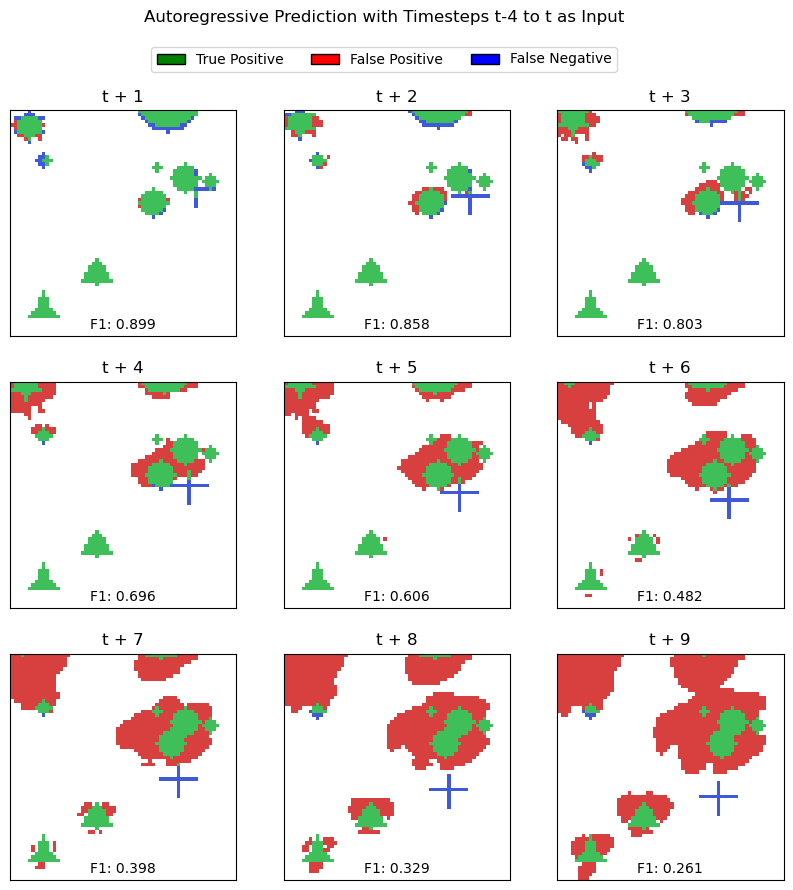

In [12]:
threshold = 0.9
num_steps = 9
n_rows = 3
n_cols = 3



fig, axs = plt.subplots(n_rows, n_cols, figsize=(10,10))
index = 0
for i in range(n_rows):
    for j in range(n_cols):
        
        original = (data[4][5 + index] > threshold).astype(int)
        reconstruction = (image[0][index] > threshold).astype(int)

        match = np.array([(original == 1) & (reconstruction == 1)], dtype=int).squeeze(0)
        print(original.shape, reconstruction.shape, match.shape)
        

        img = original + 2* reconstruction + match
        print(img.shape)
        

        rgb = np.ones((img.shape[0], img.shape[1], 3))

        rgb[img == 0] = [1, 1, 1]  # white
        rgb[img == 1] = [0.25, 0.35, 0.85]
        rgb[img == 2] = [0.85, 0.25, 0.25]
        rgb[img == 4] = [0.25, 0.75, 0.35]
        axs[i][j].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        axs[i][j].imshow(rgb)
        axs[i][j].set_title(f"t + {index + 1}")

        tp = np.sum(match)
        precision = tp / np.sum(reconstruction == 1)

        fn = np.sum(np.array([(original == 1) & (reconstruction == 0)], dtype=int))
        recall = tp/(tp+fn)
        f1 = 2*(precision * recall)/(precision+recall)
        axs[i][j].text(0.5, 0.08, f"F1: {f1:.3f}", ha='center', va='top', transform=axs[i][j].transAxes)

        index += 1



legend_elements = [
    Patch(facecolor='green', edgecolor='black', label='True Positive'),
    Patch(facecolor='red', edgecolor='black', label='False Positive'),
    Patch(facecolor='blue', edgecolor='black', label='False Negative')
]
fig.legend(handles=legend_elements, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0.95))
fig.suptitle("Autoregressive Prediction with Timesteps t-4 to t as Input")
plt.show()

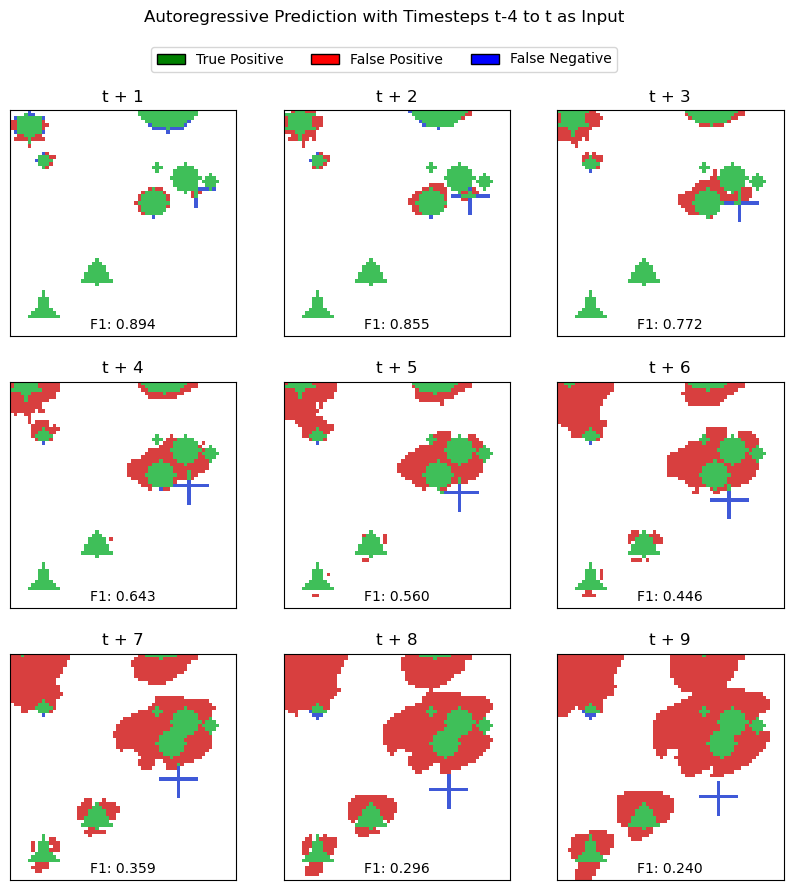

{'F1': np.float64(0.23964868255959854),
 'correct_pixels': 191,
 'total_pixels': 4096,
 'output_path': ''}

In [16]:
import prediction_vis as fp

predictions = image[0]
targets = data[4]

fp.visualize_time_series_grid_difference(predictions, targets, '', show_window=True, save_image=False, threshold=0.5)
